## Question 1: [Index] S&P 500 Stocks Added to the Index

In [1]:
#!pip install yfinance

In [2]:
import numpy as np
import pandas as pd

from datetime import datetime, timedelta

import yfinance as yf

import requests
from bs4 import BeautifulSoup
import re

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Wikipedia URL
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

# Fetch the page content
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

In [4]:
# Find the first table on the page (which contains the S&P 500 companies)
table = soup.find('table', {'id': 'constituents'})

In [5]:
# Prepare lists for the columns
tickers = []
names = []
date_added = []

In [6]:
# Loop through the table rows
for row in table.find_all('tr')[1:]:  # Skip the header
    cols = row.find_all('td')
    if len(cols) >= 2:
        ticker = cols[0].text.strip()
        name = cols[1].text.strip()
        date = cols[5].text.strip()
        tickers.append(ticker)
        names.append(name)
        date_added.append(date) 

#### 1.1  DataFrame with company tickers, names, and the year they were added

In [7]:
# Create DataFrame
df = pd.DataFrame({
    'Ticker': tickers,
    'Company Name': names,
    'Date Added': date_added
})

In [8]:
df.head()

,Ticker,Company Name,Date Added
0,MMM,3M,1957-03-04
1,AOS,A. O. Smith,2017-07-26
2,ABT,Abbott Laboratories,1957-03-04
3,ABBV,AbbVie,2012-12-31
4,ACN,Accenture,2011-07-06


#### 1.2 Extract the year from the addition date and calculate the number of stocks added each year

In [9]:
df['Date Added'] = pd.to_datetime(df['Date Added'], format='%Y-%m-%d')
df['Year Added'] = df['Date Added'].apply(lambda x: x.year)

In [10]:
df.head()

,Ticker,Company Name,Date Added,Year Added
0,MMM,3M,1957-03-04,1957
1,AOS,A. O. Smith,2017-07-26,2017
2,ABT,Abbott Laboratories,1957-03-04,1957
3,ABBV,AbbVie,2012-12-31,2012
4,ACN,Accenture,2011-07-06,2011


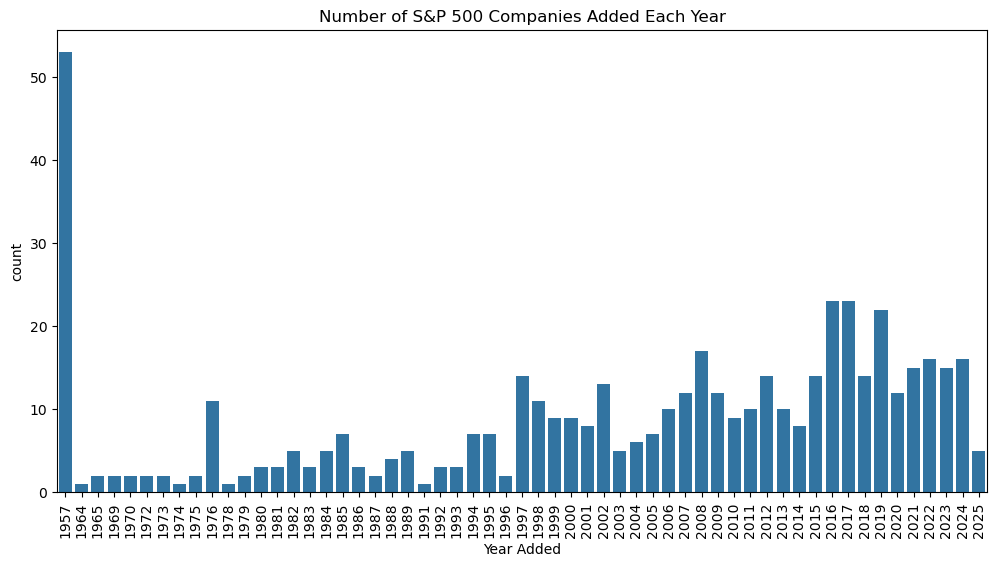

In [11]:
plt.figure(figsize=(12, 6))
# Count the number of companies added each year
sns.countplot(data=df, x='Year Added')
plt.xticks(rotation=90)
plt.title('Number of S&P 500 Companies Added Each Year')

plt.show()

#### 1.3 The year with the highest number of additions is 2017 with 23 companies added

In [12]:
df.groupby('Year Added')['Ticker'].nunique().sort_values(ascending=False).head(5)

Year Added
1957    53
2017    23
2016    23
2019    22
2008    17
Name: Ticker, dtype: int64

#### 1.4 How many current S&P 500 stocks have been in the index for more than 20 years?

In [13]:
url = "https://raw.githubusercontent.com/fja05680/sp500/refs/heads/master/sp500_ticker_start_end.csv"
sp500_ticker_start_end = pd.read_csv(url)
sp500_ticker_start_end.head()

,ticker,start_date,end_date
0,A,2000-06-05,NaN
1,AABA,1999-12-08,2017-06-19
2,AAL,1996-01-02,1997-01-15
3,AAL,2015-03-23,2024-09-23
4,AAMRQ,1996-01-02,2003-03-14


In [14]:
# Convert date columns
sp500_ticker_start_end['start_date'] = pd.to_datetime(sp500_ticker_start_end['start_date'], errors='coerce')
sp500_ticker_start_end['end_date'] = pd.to_datetime(sp500_ticker_start_end['end_date'], errors='coerce')


In [15]:
# Use today's date for companies still in the index (end_date is NaT)
sp500_ticker_start_end['end_date_filled'] = sp500_ticker_start_end['end_date'].fillna(pd.Timestamp.today())

# Calculate years in index
sp500_ticker_start_end['years_in_index'] = (sp500_ticker_start_end['end_date_filled'] - sp500_ticker_start_end['start_date']).dt.days / 365.25

In [16]:
sp500_ticker_start_end['years_in_index'] = round(sp500_ticker_start_end['years_in_index'],1)

In [17]:
# Filter for current S&P 500 members added over 20 years ago
mask = (sp500_ticker_start_end['years_in_index'] > 20) & (sp500_ticker_start_end['end_date'].isna())
sp500_ticker_start_end[mask].sort_values(by='years_in_index', ascending=False).head(10)

,ticker,start_date,end_date,end_date_filled,years_in_index
590,IP,1996-01-02,NaT,2025-06-03 19:35:28.937258,29.4
6,AAPL,1996-01-02,NaT,2025-06-03 19:35:28.937258,29.4
600,ITW,1996-01-02,NaT,2025-06-03 19:35:28.937258,29.4
607,JCI,1996-01-02,NaT,2025-06-03 19:35:28.937258,29.4
614,JNJ,1996-01-02,NaT,2025-06-03 19:35:28.937258,29.4
621,JPM,1996-01-02,NaT,2025-06-03 19:35:28.937258,29.4
623,K,1996-01-02,NaT,2025-06-03 19:35:28.937258,29.4
628,KEY,1996-01-02,NaT,2025-06-03 19:35:28.937258,29.4
636,KMB,1996-01-02,NaT,2025-06-03 19:35:28.937258,29.4
641,KO,1996-01-02,NaT,2025-06-03 19:35:28.937258,29.4


In [18]:
print(f"There are {sp500_ticker_start_end[mask].shape[0]} companies that are more than 20 years in S&P500.")

There are 215 companies that are more than 20 years in S&P500.


## Question 2. [Macro] Indexes YTD

In [19]:
import yfinance as yf

In [20]:
start_date = pd.to_datetime('2025-01-01') 
end_date = pd.to_datetime('2025-05-01')

* United States - S&P 500 (^GSPC)
* China - Shanghai Composite (000001.SS)
* Hong Kong - HANG SENG INDEX (^HSI)
* Australia - S&P/ASX 200 (^AXJO)
* India - Nifty 50 (^NSEI)
* Canada - S&P/TSX Composite (^GSPTSE)
* Germany - DAX (^GDAXI)
* United Kingdom - FTSE 100 (^FTSE)
* Japan - Nikkei 225 (^N225)
* Mexico - IPC Mexico (^MXX)
* Brazil - Ibovespa (^BVSP)

In [21]:
#["^GSPC", "000001.SS", "^HSI", "^AXJO", "^NSEI", "^GSPTSE", "^GDAXI", "^FTSE", "^N225", "^MXX", "^BVSP"]


ticker_obj = yf.Ticker("^GSPC")
snp500_daily = ticker_obj.history(start = start_date, end = end_date, interval = "1d")

ticker_obj = yf.Ticker("000001.SS")
shanghai_composite_daily = ticker_obj.history(start = start_date, end = end_date, interval = "1d")

ticker_obj = yf.Ticker("^HSI")
hang_seng_daily = ticker_obj.history(start = start_date, end = end_date, interval = "1d")

ticker_obj = yf.Ticker("^AXJO")
sp_asx_daily = ticker_obj.history(start = start_date, end = end_date, interval = "1d")

ticker_obj = yf.Ticker("^NSEI")
nifty_50_daily = ticker_obj.history(start = start_date, end = end_date, interval = "1d")

ticker_obj = yf.Ticker("^GSPTSE")
sp_tsx_daily = ticker_obj.history(start = start_date, end = end_date, interval = "1d")

ticker_obj = yf.Ticker("^GDAXI")
dax_daily = ticker_obj.history(start = start_date, end = end_date, interval = "1d")

ticker_obj = yf.Ticker("^FTSE")
ftse_100_daily = ticker_obj.history(start = start_date, end = end_date, interval = "1d")

ticker_obj = yf.Ticker("^N225")
nikkei_225_daily = ticker_obj.history(start = start_date, end = end_date, interval = "1d")

ticker_obj = yf.Ticker("^MXX")
ipc_mexico_daily = ticker_obj.history(start = start_date, end = end_date, interval = "1d")

ticker_obj = yf.Ticker("^BVSP")
ibovespa_daily = ticker_obj.history(start = start_date, end = end_date, interval = "1d")

Text(0.5, 1.0, 'Stock Market Indices Comparison')

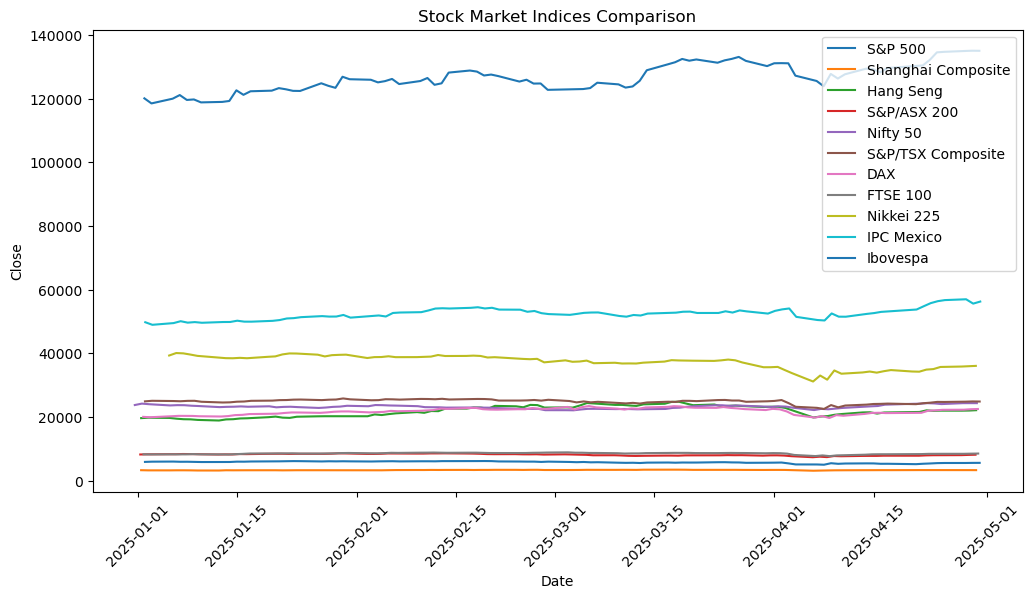

In [22]:
plt.figure(figsize=(12, 6))
plt.xticks(rotation=45)

sns.lineplot(data=snp500_daily, x=snp500_daily.index, y='Close', label='S&P 500')
sns.lineplot(data=shanghai_composite_daily, x=shanghai_composite_daily.index, y='Close', label='Shanghai Composite')
sns.lineplot(data=hang_seng_daily, x=hang_seng_daily.index, y='Close', label='Hang Seng')
sns.lineplot(data=sp_asx_daily, x=sp_asx_daily.index, y='Close', label='S&P/ASX 200')
sns.lineplot(data=nifty_50_daily, x=nifty_50_daily.index, y='Close', label='Nifty 50')
sns.lineplot(data=sp_tsx_daily, x=sp_tsx_daily.index, y='Close', label='S&P/TSX Composite')
sns.lineplot(data=dax_daily, x=dax_daily.index, y='Close', label='DAX')
sns.lineplot(data=ftse_100_daily, x=ftse_100_daily.index, y='Close', label='FTSE 100')
sns.lineplot(data=nikkei_225_daily, x=nikkei_225_daily.index, y='Close', label='Nikkei 225')
sns.lineplot(data=ipc_mexico_daily, x=ipc_mexico_daily.index, y='Close', label='IPC Mexico')
sns.lineplot(data=ibovespa_daily, x=ibovespa_daily.index, y='Close', label='Ibovespa')
plt.title('Stock Market Indices Comparison')

#### How many indexes (out of 10) have better year-to-date returns than the US (S&P 500) as of May 1, 2025?

In [23]:
# year-to-date (YTD) performance function

def ytd_performance(df):
    ytd_performance = (df['Close'].iloc[-1] - df['Close'].iloc[0]) / df['Close'].iloc[0] * 100
    return ytd_performance

In [24]:
#["^GSPC", "000001.SS", "^HSI", "^AXJO", "^NSEI", "^GSPTSE", "^GDAXI", "^FTSE", "^N225", "^MXX", "^BVSP"]

ytd_snp500 = ytd_performance(snp500_daily)
ytd_shanghai_composite = ytd_performance(shanghai_composite_daily)
ytd_hang_seng = ytd_performance(hang_seng_daily)
ytd_sp_asx = ytd_performance(sp_asx_daily)
ytd_nifty_50 = ytd_performance(nifty_50_daily)
ytd_sp_tsx = ytd_performance(sp_tsx_daily)
ytd_dax = ytd_performance(dax_daily)
ytd_ftse_100 = ytd_performance(ftse_100_daily)
ytd_nikkei_225 = ytd_performance(nikkei_225_daily)
ytd_ipc_mexico = ytd_performance(ipc_mexico_daily)
ytd_ibovespa = ytd_performance(ibovespa_daily)

ytd_performances = {
    'S&P 500': ytd_snp500,
    'Shanghai Composite': ytd_shanghai_composite,
    'Hang Seng': ytd_hang_seng,
    'S&P/ASX 200': ytd_sp_asx,
    'Nifty 50': ytd_nifty_50,
    'S&P/TSX Composite': ytd_sp_tsx,
    'DAX': ytd_dax,
    'FTSE 100': ytd_ftse_100,
    'Nikkei 225': ytd_nikkei_225,
    'IPC Mexico': ytd_ipc_mexico,
    'Ibovespa': ytd_ibovespa
}

In [25]:
ytd_performances = dict(sorted(ytd_performances.items(), key=lambda item: item[1]))
ytd_performances

{'Nikkei 225': -8.297930804200304,
 'S&P 500': -5.10330074824504,
 'S&P/ASX 200': -0.9145002952478493,
 'S&P/TSX Composite': -0.22612571792915093,
 'Shanghai Composite': 0.5048172440500021,
 'Nifty 50': 2.4904237409784913,
 'FTSE 100': 2.8425901908435485,
 'DAX': 12.34637838149953,
 'Ibovespa': 12.438709677419354,
 'Hang Seng': 12.720017835921466,
 'IPC Mexico': 13.049444457570319}

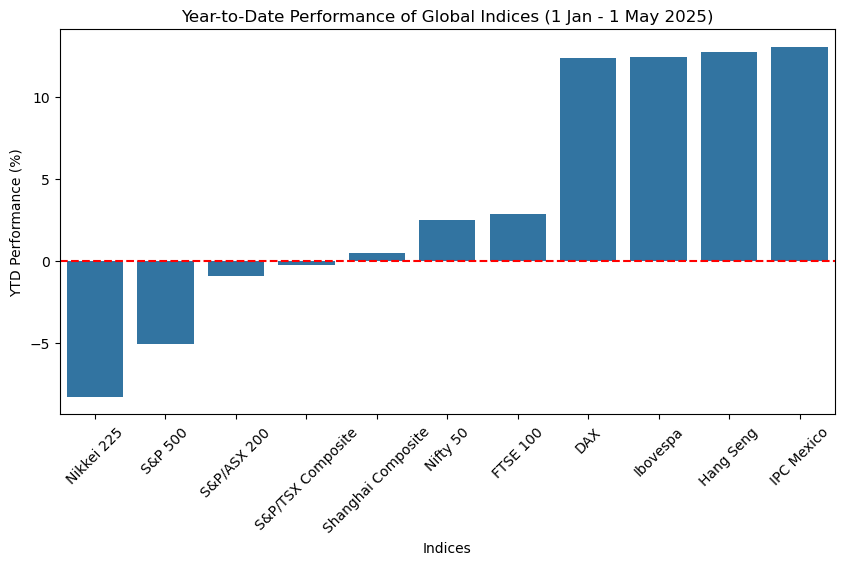

In [26]:
plt.figure(figsize=(10, 5))
plt.xticks(rotation=45) 

sns.barplot(x=list(ytd_performances.keys()), y=list(ytd_performances.values()))

plt.title('Year-to-Date Performance of Global Indices (1 Jan - 1 May 2025)')
plt.ylabel('YTD Performance (%)')
plt.xlabel('Indices')

plt.axhline(0, color='red', linestyle='--')
plt.show()

In [27]:
# How many indices have better YTD performance than the S&P 500?
better_indices = [index for index, performance in ytd_performances.items() if performance > ytd_performances['S&P 500']]
print(f"{len(better_indices)} indices have better YTD performance than the S&P 500.") 


9 indices have better YTD performance than the S&P 500.


### 2.2 How many of these indexes have better returns than the S&P 500 over 3, 5, and 10 year periods? Do you see the same trend? 

In [28]:
# Define index symbols
indices = ["^GSPC", "000001.SS", "^HSI", "^AXJO", "^NSEI", "^GSPTSE",
           "^GDAXI", "^FTSE", "^N225", "^MXX", "^BVSP"]

In [29]:
# Define target periods
date_offsets = {
    "3Y": end_date - timedelta(days=3*365),
    "5Y": end_date - timedelta(days=5*365),
    "10Y": end_date - timedelta(days=10*365)
}

In [30]:
# Store results
results = []

for symbol in indices:
    data = {'Index': symbol}
    try:
        # Download data (with small buffer around the 10-year mark)
        ticker = yf.Ticker(symbol)
        hist = ticker.history(
            start=date_offsets["10Y"] - timedelta(days=5),
            end=end_date + timedelta(days=1),
            interval='1d'
        )

        # Use naive datetime (remove timezone if present)
        hist.index = hist.index.tz_localize(None)
        hist = hist[['Close']].dropna()

        # Get latest price up to May 1, 2025
        price_today = hist[hist.index <= end_date].iloc[-1]['Close']

        # Get returns for each period
        for label, date in date_offsets.items():
            past_price = hist[hist.index <= date].iloc[-1]['Close']
            data[f'{label}_Return'] = (price_today / past_price - 1) * 100
    except Exception as e:
        print(f"Error with {symbol}: {e}")
        data[f'3Y_Return'] = data[f'5Y_Return'] = data[f'10Y_Return'] = None
    results.append(data)

In [31]:
# Convert to DataFrame
returns_df = pd.DataFrame(results)
returns_df

,Index,3Y_Return,5Y_Return,10Y_Return
0,^GSPC,34.864689,97.976487,165.035075
1,000001.SS,7.612943,14.648145,-26.814921
2,^HSI,4.884065,-10.242743,-21.349909
3,^AXJO,10.869744,55.275553,39.778637
4,^NSEI,42.562875,146.799646,192.058866
5,^GSPTSE,19.830663,69.597067,61.350900
6,^GDAXI,61.395129,107.123245,93.608190
7,^FTSE,12.620943,47.434535,21.626107
8,^N225,35.922072,85.797702,86.632141
9,^MXX,8.425565,54.261345,24.361595


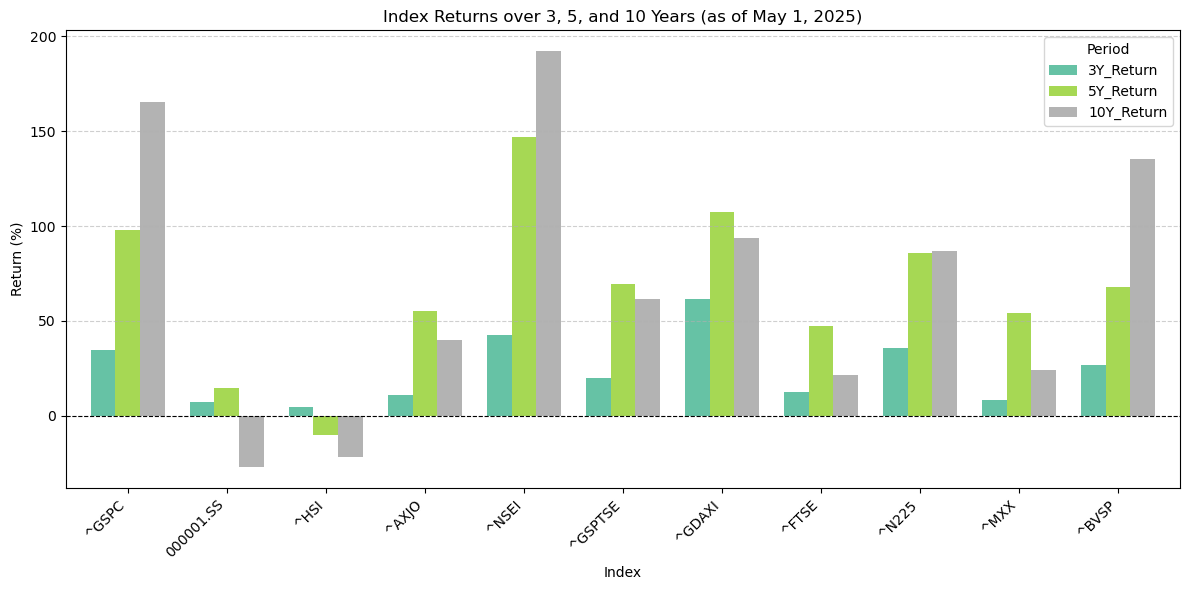

In [32]:
# Set index names for x-axis labels
returns_df_plot = returns_df.set_index('Index')

# Plot setup
fig, ax = plt.subplots(figsize=(12, 6))
returns_df_plot[['3Y_Return', '5Y_Return', '10Y_Return']].plot(
    kind='bar',
    ax=ax,
    width=0.75,
    colormap='Set2'
)

# Titles and labels
plt.title("Index Returns over 3, 5, and 10 Years (as of May 1, 2025)")
plt.ylabel("Return (%)")
plt.xlabel("Index")
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.legend(title="Period")
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.show()

## 3. Question 3. [Index] S&P 500 Market Corrections Analysis

1. Download S&P 500 historical data (1950-present) using yfinance

In [33]:
ticker_obj = yf.Ticker("^GSPC")
snp500 = ticker_obj.history(start = "1950-01-01", interval = "1d")
snp500 = snp500[['Close']]

# Convert the index to datetime
snp500.index = pd.to_datetime(snp500.index.date)

2. Identify all-time high points (where price exceeds all previous prices)

In [34]:
# Calculate the running maximum and ATH flags
snp500['RunningMax'] = snp500['Close'].cummax()
snp500['ATH'] = snp500['Close'] > snp500['Close'].shift(1).cummax().fillna(0)

In [35]:
snp500.head()

,Close,RunningMax,ATH
1950-01-03,16.66,16.66,True
1950-01-04,16.85,16.85,True
1950-01-05,16.93,16.93,True
1950-01-06,16.98,16.98,True
1950-01-09,17.08,17.08,True


In [36]:
snp500[snp500['ATH']]['Close']

1950-01-03      16.660000
1950-01-04      16.850000
1950-01-05      16.930000
1950-01-06      16.980000
1950-01-09      17.080000
                 ...     
2024-12-04    6086.490234
2024-12-06    6090.270020
2025-01-23    6118.709961
2025-02-18    6129.580078
2025-02-19    6144.149902
Name: Close, Length: 1447, dtype: float64

In [37]:
snp500['ATH'].value_counts()

ATH
False    17527
True      1447
Name: count, dtype: int64

3. & 4. For each pair of consecutive all-time highs, find the minimum price in between and Calculate drawdown percentages: (high - low) / high × 100

In [38]:
#Get the index positions of ATHs
ath_indices = snp500[snp500['ATH']].index.to_list()

In [39]:
#Iterate through each pair of consecutive ATHs and find min Close in between
ath_dips = []


for i in range(len(ath_indices) - 1):
    start_date = ath_indices[i]
    end_date = ath_indices[i + 1]
    
    # Get the minimum Close *between* the two ATHs (exclusive)
    dip_period = snp500.loc[start_date:end_date].iloc[1:-1]  # exclude ATHs
    if not dip_period.empty:
        min_close = dip_period['Close'].min()
        min_date = dip_period['Close'].idxmin()
        ath_start_price = snp500.loc[start_date, 'Close']
        
        # Calculate the drawdown percentage
        drawdown_pct = ((ath_start_price - min_close) / ath_start_price) * 100


        ath_dips.append({
            'ATH_1': start_date,
            'ATH_1_Price': ath_start_price,
            'ATH_2': end_date,
            'Min_Close': min_close,
            'Min_Close_Date': min_date,
            'Drawdown_%': round(drawdown_pct, 1)
        })


In [40]:
#Convert to DataFrame to view results
ath_dips_df = pd.DataFrame(ath_dips)
ath_dips_df.head()

,ATH_1,ATH_1_Price,ATH_2,Min_Close,Min_Close_Date,Drawdown_%
0,1950-01-09,17.080000,1950-01-11,17.030001,1950-01-10,0.3
1,1950-01-11,17.090000,1950-02-02,16.670000,1950-01-13,2.5
2,1950-02-06,17.320000,1950-03-15,16.990000,1950-02-16,1.9
3,1950-03-16,17.490000,1950-03-22,17.440001,1950-03-20,0.3
4,1950-03-23,17.559999,1950-04-05,17.290001,1950-03-31,1.5


5. Filter for corrections with at least 5% drawdown

In [41]:
ath_dips_df = ath_dips_df[ath_dips_df['Drawdown_%'] >= 5].reset_index(drop=True)
ath_dips_df.head()

,ATH_1,ATH_1_Price,ATH_2,Min_Close,Min_Close_Date,Drawdown_%
0,1950-06-12,19.400000,1950-09-22,16.680000,1950-07-17,14.0
1,1950-11-24,20.320000,1950-12-28,19.000000,1950-12-04,6.5
2,1951-05-03,22.809999,1951-08-02,20.959999,1951-06-29,8.1
3,1951-10-15,23.850000,1952-01-03,22.400000,1951-11-23,6.1
4,1952-01-22,24.660000,1952-06-26,23.090000,1952-02-20,6.4


6. Calculate the duration in days for each correction period

In [42]:
ath_dips_df['ATH_1'] = pd.to_datetime(ath_dips_df['ATH_1'])
ath_dips_df['Min_Close_Date'] = pd.to_datetime(ath_dips_df['Min_Close_Date'])

ath_dips_df['Correction_Period'] = (ath_dips_df['Min_Close_Date'] - ath_dips_df['ATH_1']).dt.days

In [43]:
ath_dips_df.sort_values(by='Drawdown_%', ascending=False).head(10)

,ATH_1,ATH_1_Price,ATH_2,Min_Close,Min_Close_Date,Drawdown_%,Correction_Period
58,2007-10-09,1565.150024,2013-03-28,676.530029,2009-03-09,56.8,517
56,2000-03-24,1527.459961,2007-05-30,776.760010,2002-10-09,49.1,929
24,1973-01-11,120.239998,1980-07-17,62.279999,1974-10-03,48.2,630
22,1968-11-29,108.370003,1972-03-06,69.290001,1970-05-26,36.1,543
67,2020-02-19,3386.149902,2020-08-18,2237.399902,2020-03-23,33.9,33
35,1987-08-25,336.769989,1989-07-26,223.919998,1987-12-04,33.5,101
15,1961-12-12,72.639999,1963-09-03,52.320000,1962-06-26,28.0,196
27,1980-11-28,140.520004,1982-11-03,102.419998,1982-08-12,27.1,622
70,2022-01-03,4796.560059,2024-01-19,3577.030029,2022-10-12,25.4,282
18,1966-02-09,94.059998,1967-05-04,73.199997,1966-10-07,22.2,240


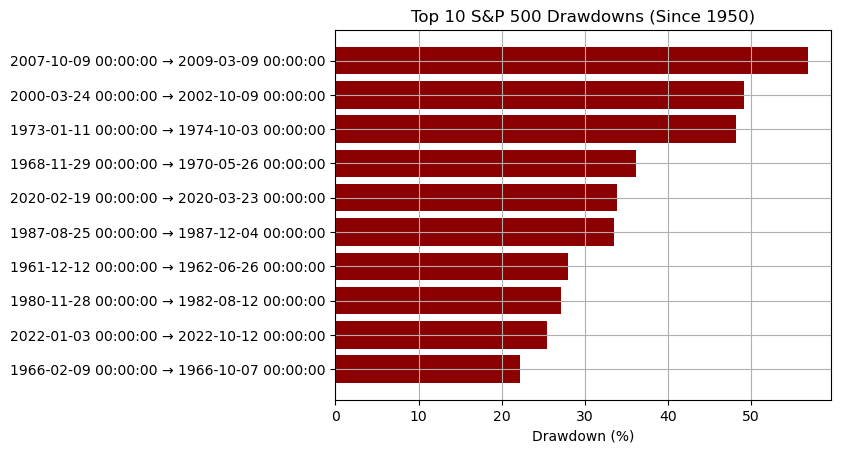

In [44]:
top_drawdowns = ath_dips_df.sort_values('Drawdown_%', ascending=False).head(10)

#plt.figure(figsize=(10, 6))
plt.barh(
    [f"{row.ATH_1} → {row.Min_Close_Date}" for row in top_drawdowns.itertuples()],
    top_drawdowns['Drawdown_%'],
    color='darkred'
)
plt.xlabel("Drawdown (%)")
plt.title("Top 10 S&P 500 Drawdowns (Since 1950)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()


7. Determine the 25th, 50th (median), and 75th percentiles for correction durations

In [45]:
ath_dips_df['Correction_Period'].describe()

count     73.000000
mean     110.808219
std      177.160603
min        7.000000
25%       21.000000
50%       39.000000
75%       87.000000
max      929.000000
Name: Correction_Period, dtype: float64

In [46]:
print(f"The median duration of significant market corrections in the S&P 500 index is {round(ath_dips_df['Correction_Period'].median())} days.") 

The median duration of significant market corrections in the S&P 500 index is 39 days.


## Additional Visualization

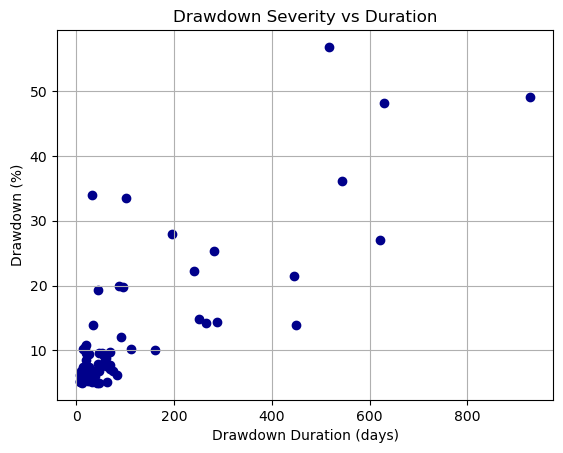

In [47]:
#plt.figure(figsize=(10, 6))
plt.scatter(ath_dips_df['Correction_Period'], ath_dips_df['Drawdown_%'], color='darkblue')
plt.xlabel("Drawdown Duration (days)")
plt.ylabel("Drawdown (%)")
plt.title("Drawdown Severity vs Duration")
plt.grid(True)
plt.show()

In [48]:
import plotly.graph_objects as go

In [49]:
fig = go.Figure()

# Price line
fig.add_trace(go.Scatter(
    x=snp500.index, y=snp500['Close'],
    mode='lines', name='S&P 500', line=dict(color='blue')
))

# Drawdown arrows
for row in ath_dips_df.itertuples():
    fig.add_trace(go.Scatter(
        x=[row.ATH_1, row.Min_Close_Date],
        y=[row.ATH_1_Price, row.Min_Close],
        mode='lines+markers',
        marker=dict(size=6, color='red'),
        line=dict(dash='dot', color='red'),
        name=f'Drawdown: {row._6}%'  # _6 is the 6th column (Drawdown_%) in the namedtuple
    ))

fig.update_layout(
    title="S&P 500 Drawdowns (ATH to Troughs)",
    xaxis_title="Date",
    yaxis_title="S&P 500 Close Price",
    template="plotly_white",
    showlegend=False,
    height=600
)

fig.show()

## Question 4. [Stocks] Earnings Surprise Analysis for Amazon (AMZN)

4.1 Load earnings data from CSV (ha1_Amazon.csv) containing earnings dates, EPS estimates, and actual EPS

In [50]:
amazon_earnings = pd.read_csv("ha1_Amazon.csv", sep = ";")
amazon_earnings.head(10)

,Symbol,Company,Earnings Date,EPS Estimate,Reported EPS,Surprise (%)
0,AMZN,Amazon.com Inc,"April 29, 2026 at 6 AM EDT",-,-,-
1,AMZN,Amazon.com Inc,"February 4, 2026 at 4 PM EST",-,-,-
2,AMZN,Amazon.com Inc,"October 29, 2025 at 6 AM EDT",-,-,-
3,AMZN,Amazon.com Inc,"July 30, 2025 at 4 PM EDT",-,-,-
4,AMZN,"Amazon.com, Inc.","May 1, 2025 at 4 PM EDT",???.36,???.59,+16.74
5,AMZN,"Amazon.com, Inc.","February 6, 2025 at 4 PM EST",???.49,???.86,+24.47
6,AMZN,"Amazon.com, Inc.","October 31, 2024 at 4 PM EDT",???.14,???.43,+25.17
7,AMZN,"Amazon.com, Inc.","August 1, 2024 at 4 PM EDT",01.???,???.26,+22.58
8,AMZN,"Amazon.com, Inc.","April 30, 2024 at 4 PM EDT",0.83,0.98,+17.91
9,AMZN,"Amazon.com, Inc.","February 1, 2024 at 4 PM EST",0.8,1,+24.55


In [51]:
# Normalize company names
amazon_earnings["Company"] = amazon_earnings["Company"].str.replace(",", "").str.strip()

In [52]:
# Function to extract date part
def extract_date_only(s):
    if pd.isna(s):
        return pd.NaT
    # Remove everything after the date (e.g., " at 6 AM EDT")
    date_str = re.sub(r"\s+at.*", "", s)
    return pd.to_datetime(date_str, errors="coerce").date()

# Apply to the Earnings Date column
amazon_earnings["Earnings Date"] = amazon_earnings["Earnings Date"].apply(extract_date_only)
amazon_earnings["Earnings Date"] = pd.to_datetime(amazon_earnings["Earnings Date"])

In [53]:
# Clean EPS columns — fix '???' patterns
def clean_eps(value):
    if pd.isna(value) or not isinstance(value, str):
        return value
    value = re.sub(r"\?\?\?\.([0-9]+)", r"1.\1", value)    # '???.xx' → '1.xx'
    value = re.sub(r"([0-9]+)\.\?\?\?", r"\1.03", value)    # 'xx.???' → 'xx.03'
    return value

amazon_earnings["EPS Estimate"] = amazon_earnings["EPS Estimate"].apply(clean_eps)
amazon_earnings["Reported EPS"] = amazon_earnings["Reported EPS"].apply(clean_eps)

In [54]:
#Remove '+' in Surprise (%) and convert to float
amazon_earnings["Surprise (%)"] = amazon_earnings["Surprise (%)"].str.replace("+", "", regex=False)


In [55]:
#Convert EPS and Surprise columns to numeric (float → then int if needed)
for col in ["EPS Estimate", "Reported EPS", "Surprise (%)"]:
    amazon_earnings[col] = pd.to_numeric(amazon_earnings[col], errors="coerce")

In [56]:
amazon_earnings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Symbol         116 non-null    object        
 1   Company        116 non-null    object        
 2   Earnings Date  116 non-null    datetime64[ns]
 3   EPS Estimate   88 non-null     float64       
 4   Reported EPS   96 non-null     float64       
 5   Surprise (%)   112 non-null    float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 5.6+ KB


In [57]:
amazon_earnings.dropna(subset=["EPS Estimate", "Reported EPS", "Surprise (%)"], how="all", inplace=True)
amazon_earnings.reset_index(drop=True, inplace=True)

In [58]:
amazon_earnings.head()

,Symbol,Company,Earnings Date,EPS Estimate,Reported EPS,Surprise (%)
0,AMZN,Amazon.com Inc.,2025-05-01,1.36,1.59,16.74
1,AMZN,Amazon.com Inc.,2025-02-06,1.49,1.86,24.47
2,AMZN,Amazon.com Inc.,2024-10-31,1.14,1.43,25.17
3,AMZN,Amazon.com Inc.,2024-08-01,1.03,1.26,22.58
4,AMZN,Amazon.com Inc.,2024-04-30,0.83,0.98,17.91


4.2 Download complete historical price data using yfinance

In [102]:
ticker_obj = yf.Ticker("AMZN")
amzn_daily = ticker_obj.history(interval = "1d", period="max", end = "2025-05-01")

In [103]:
amzn_daily.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-04-24 00:00:00-04:00,180.919998,186.740005,180.179993,186.539993,43763200,0.0,0.0
2025-04-25 00:00:00-04:00,187.619995,189.940002,185.490005,188.990005,36414300,0.0,0.0
2025-04-28 00:00:00-04:00,190.110001,190.220001,184.889999,187.699997,33224700,0.0,0.0
2025-04-29 00:00:00-04:00,183.990005,188.020004,183.679993,187.389999,41667300,0.0,0.0
2025-04-30 00:00:00-04:00,182.169998,185.050003,178.850006,184.419998,55176500,0.0,0.0


In [104]:
amzn_daily = amzn_daily[['Close']]
amzn_daily.index = pd.to_datetime(amzn_daily.index.date)
amzn_daily.head()

,Close
1997-05-15,0.097917
1997-05-16,0.086458
1997-05-19,0.085417
1997-05-20,0.081771
1997-05-21,0.071354


4.3 Calculate 2-day percentage changes for all historical dates: for each sequence of 3 consecutive trading days (Day 1, Day 2, Day 3), compute the return as Close_Day3 / Close_Day1 - 1. (Assume Day 2 may correspond to the earnings announcement.)

In [105]:
amzn_daily['2day_change'] = amzn_daily['Close'].shift(-2) / amzn_daily['Close'] - 1
amzn_daily

,Close,2day_change
1997-05-15,0.097917,-0.127659
1997-05-16,0.086458,-0.054211
1997-05-19,0.085417,-0.164639
1997-05-20,0.081771,-0.146494
1997-05-21,0.071354,0.051097
...,...,...
2025-04-24,186.539993,0.006219
2025-04-25,188.990005,-0.008466
2025-04-28,187.699997,-0.017475
2025-04-29,187.389999,NaN


4 Identify positive earnings surprises (where "actual EPS > estimated EPS" OR "Surprise (%)>0")

In [106]:
amazon_earnings_positive = amazon_earnings[(amazon_earnings['Reported EPS'] > 
                                            amazon_earnings['EPS Estimate'])].reset_index(drop=True)
amazon_earnings_positive.shape

(37, 6)

5 Calculate 2-day percentage changes following positive earnings surprises

In [107]:
amzn_daily = amzn_daily.reset_index(drop=False)
amzn_daily.rename(columns={"index": "Date"}, inplace=True)

In [108]:
amazon_positive = pd.merge(amzn_daily, 
                           amazon_earnings_positive[["Earnings Date", "Surprise (%)"]], 
                           left_on = 'Date', 
                           right_on='Earnings Date', 
                           how='inner')

amazon_positive.head()

,Date,Close,2day_change,Earnings Date,Surprise (%)
0,2006-02-02,2.1370,-0.112073,2006-02-02,120.86
1,2008-07-23,3.5270,0.110150,2008-07-23,42.09
2,2009-01-29,2.5000,0.223000,2009-01-29,33.20
3,2010-10-21,8.2485,0.024429,2010-10-21,7.28
4,2011-01-27,9.2225,-0.080293,2011-01-27,3.03


In [109]:
amazon_positive['2day_change'].describe()

count    36.000000
mean      0.018895
std       0.088177
min      -0.136513
25%      -0.053354
50%       0.019883
75%       0.084976
max       0.223000
Name: 2day_change, dtype: float64

6 Compare the median 2-day percentage change for positive surprises vs. all historical dates

In [110]:
amazon_positive['2day_change'].median()

0.019883346562319937

In [111]:
amzn_daily['2day_change'].median()

0.0016349067076996127

In [112]:
print(f"2-day change after positive earnings surprise: {round(amazon_positive['2day_change'].median() * 100, 2)}%")
print(f"2-day change all historical dates: {round(amzn_daily['2day_change'].median() * 100, 2)}%")

2-day change after positive earnings surprise: 1.99%
2-day change all historical dates: 0.16%


### Additional: Is there a correlation between the magnitude of the earnings surprise and the stock price reaction? 

In [113]:
correlation = pd.merge(amzn_daily,
                       amazon_earnings_positive[["Earnings Date", "Surprise (%)"]], 
                        left_on = 'Date', 
                        right_on='Earnings Date', 
                        how='right')
correlation

,Date,Close,2day_change,Earnings Date,Surprise (%)
0,NaT,NaN,NaN,2025-05-01,16.74
1,2025-02-06,238.830002,-0.023824,2025-02-06,24.47
2,2024-10-31,186.399994,0.050322,2024-10-31,25.17
3,2024-08-01,184.070007,-0.125224,2024-08-01,22.58
4,2024-04-30,175.000000,0.055543,2024-04-30,17.91
5,2024-02-01,159.279999,0.069249,2024-02-01,24.55
6,2023-10-26,119.570000,0.109894,2023-10-26,60.85
7,2023-08-03,128.910004,0.103250,2023-08-03,85.73
8,2023-04-27,109.820000,-0.070752,2023-04-27,46.36
9,2023-02-02,112.910004,-0.095031,2023-02-02,42.56


In [114]:
correlation[['2day_change', 'Surprise (%)']].corr()

,2day_change,Surprise (%)
2day_change,1.000000,0.116282
Surprise (%),0.116282,1.000000


In [115]:
correlation[['Close', 'Surprise (%)']].corr()

,Close,Surprise (%)
Close,1.000000,-0.053914
Surprise (%),-0.053914,1.000000


### Does the market react differently to earnings surprises during bull vs. bear markets?

In [116]:
# Step 1: Download historical data for S&P500
ticker_obj = yf.Ticker("^GSPC")
spx = ticker_obj.history(start = "1997-05-15", interval = "1d")
#spx = yf.download("^GSPC", start="1997-05-15")

# Step 2: Keep only closing prices
spx = spx[["Close"]].rename(columns={"Close": "SPX_Close"})
spx.head()

,SPX_Close
Date,
1997-05-15 00:00:00-04:00,841.880005
1997-05-16 00:00:00-04:00,829.750000
1997-05-19 00:00:00-04:00,833.270020
1997-05-20 00:00:00-04:00,841.659973
1997-05-21 00:00:00-04:00,839.349976


In [117]:
# Step 3: Compute rolling max and drawdown
spx["Rolling_Max"] = spx["SPX_Close"].cummax()
spx["Drawdown"] = (spx["SPX_Close"] - spx["Rolling_Max"]) / spx["Rolling_Max"]

In [118]:
# Step 4: Define market regime
spx["Market_Regime"] = "Bull"
spx.loc[spx["Drawdown"] <= -0.20, "Market_Regime"] = "Bear"

In [119]:
spx['Market_Regime'].value_counts()

Market_Regime
Bull    5225
Bear    1831
Name: count, dtype: int64

In [120]:
spx.index = pd.to_datetime(spx.index.date)
spx.reset_index(drop=False, inplace=True)
spx.rename(columns={"index": "Date"}, inplace=True)

In [121]:
spx

,Date,SPX_Close,Rolling_Max,Drawdown,Market_Regime
0,1997-05-15,841.880005,841.880005,0.000000,Bull
1,1997-05-16,829.750000,841.880005,-0.014408,Bull
2,1997-05-19,833.270020,841.880005,-0.010227,Bull
3,1997-05-20,841.659973,841.880005,-0.000261,Bull
4,1997-05-21,839.349976,841.880005,-0.003005,Bull
...,...,...,...,...,...
7051,2025-05-27,5921.540039,6144.149902,-0.036231,Bull
7052,2025-05-28,5888.549805,6144.149902,-0.041601,Bull
7053,2025-05-29,5912.169922,6144.149902,-0.037756,Bull
7054,2025-05-30,5911.689941,6144.149902,-0.037834,Bull


In [122]:
# Step 5: Join SPX regime to AMZN prices
market_data = pd.merge(correlation,
                          spx[["Date", "Market_Regime"]], 
                            left_on = 'Date', 
                            right_on='Date', 
                            how='inner')
# Step 6: Clean up
market_data.drop(columns=["Earnings Date"], inplace=True)


market_data.head(10)


,Date,Close,2day_change,Surprise (%),Market_Regime
0,2025-02-06,238.830002,-0.023824,24.47,Bull
1,2024-10-31,186.399994,0.050322,25.17,Bull
2,2024-08-01,184.070007,-0.125224,22.58,Bull
3,2024-04-30,175.000000,0.055543,17.91,Bull
4,2024-02-01,159.279999,0.069249,24.55,Bull
5,2023-10-26,119.570000,0.109894,60.85,Bull
6,2023-08-03,128.910004,0.103250,85.73,Bull
7,2023-04-27,109.820000,-0.070752,46.36,Bull
8,2023-02-02,112.910004,-0.095031,42.56,Bull
9,2022-07-28,122.279999,0.107213,24.90,Bull


In [123]:
# Compare Average Price Reactions
avg_changes = market_data.groupby("Market_Regime")[["2day_change", "Surprise (%)"]].mean()
print(avg_changes)

               2day_change  Surprise (%)
Market_Regime                           
Bear              0.123714     20.240000
Bull              0.012730     84.899706


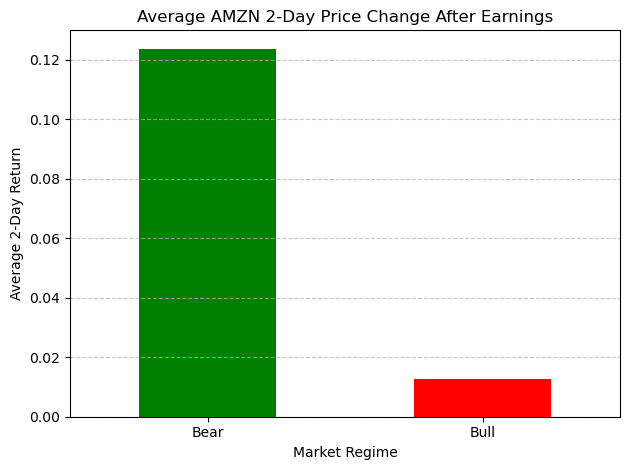

In [124]:
# Plot average 2-day price change in bull vs. bear markets
avg_changes["2day_change"].plot(kind="bar", color=["green", "red"])
plt.title("Average AMZN 2-Day Price Change After Earnings")
plt.ylabel("Average 2-Day Return")
plt.xlabel("Market Regime")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [125]:
# Correlation in each regime
bull_corr = market_data[market_data["Market_Regime"] == "Bull"][["2day_change", "Surprise (%)"]].corr().iloc[0,1]
bear_corr = market_data[market_data["Market_Regime"] == "Bear"][["2day_change", "Surprise (%)"]].corr().iloc[0,1]

print(f"Bull market correlation: {bull_corr:.2f}")
print(f"Bear market correlation: {bear_corr:.2f}")


Bull market correlation: 0.16
Bear market correlation: 1.00
